# Assembly MGXS

This notebook creates a 3x3 assembly with one position with no fuel.  MGXS are tallied over 10 groups.

In [1]:
%matplotlib inline

import numpy as np
from uncertainties import ufloat

import openmc

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
uo2 = openmc.Material(name='fuel')
uo2.add_element('U', 1, enrichment=3.2)
uo2.add_element('O', 2)
uo2.set_density('g/cc', 10.341)

In [3]:
water = openmc.model.borated_water(boron_ppm=400, temperature=600)

/home/bforget/.local/lib/python3.8/site-packages/openmc/data/data.py:335: UserWarning: Results are not valid for temperatures above saturation (above the boiling point).
  warn("Results are not valid for temperatures above saturation "


In [4]:
materials = openmc.Materials([uo2, water])

In [5]:
materials.export_to_xml()

In [6]:
#fuel pin dimensions, 0.4 cm sqaure of fuel in 1.2 cm square moderator
pin_radius = 0.4
pitch = 1.2

To simplify the problem, clad and the gap were omitted.

In [7]:
# square fuel in square box, vacuum boundaries were use on the outside for calculating CPs
pin = openmc.ZCylinder(x0=0.0, y0=0.0, r=pin_radius)
xy_box = openmc.model.rectangular_prism(3*pitch, 3*pitch,
        boundary_type='reflective')
z0 = openmc.ZPlane(z0=-10, boundary_type='reflective')
z1 = openmc.ZPlane(z0=10, boundary_type='reflective')

In [8]:
fuel = openmc.Cell(cell_id=1, name='fuel', fill=uo2)
fuel.region = -pin
mod = openmc.Cell(cell_id=2, name='moderator', fill=water)
mod.region = +pin
fuel_univ = openmc.Universe(cells=(fuel, mod))

In [9]:
mod = openmc.Cell(cell_id=3, name='guide', fill=water)
guide_univ = openmc.Universe(cells=(mod, ))

In [10]:
# Build lattice with 8 fuel pins and 1 center empty guide tube
lat = openmc.RectLattice()
lat.pitch = [pitch, pitch]
lat.lower_left = [-1.5*pitch, -1.5*pitch]
lat.universes = [[fuel_univ, fuel_univ, fuel_univ],
                 [fuel_univ, fuel_univ, fuel_univ],
                 [fuel_univ, fuel_univ, guide_univ]]

In [11]:
root_cell = openmc.Cell(fill=lat)
root_cell.region = xy_box & +z0 & -z1
root = openmc.Universe(cells=(root_cell, ))
geometry = openmc.Geometry(root)
geometry.export_to_xml()

The lattice function numbers from the lower left corner (position 0,0) to the top right (position 2,2).  The bottom right corner has no fuel and is filled with water (position 0,2).

Unique pins:
- Top left corner (position 2,0)
- Middle (position 1,1)

Symmetric pins:
- Position (0,0) with (2,2)
- Position (0,1) with (1,2)
- Position (1,0) with (2,1)

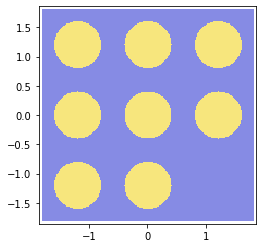

In [12]:
root.plot(width=(3.1*pitch, 3.1*pitch), color_by='material')

In [13]:
lat

RectLattice
	ID             =	3
	Name           =	
	Shape          =	(3, 3)
	Lower Left     =	[-1.7999999999999998, -1.7999999999999998]
	Pitch          =	[1.2, 1.2]
	Outer          =	None
	Universes      
1 1 1 
1 1 1 
1 1 2 

The tallies are over 10 groups with the 6.67 eV in group 5 (group 1 being fast) and the other two main resonances in group 4.

In [14]:
groups = openmc.mgxs.EnergyGroups((0.0, 0.058, 0.14, 0.28, 0.625, 4.0, 10.0, 40.0, 5530.0,
                                   0.821e6, 20.0e6))

# Instantiate an MGXS library.
mgxs_lib = openmc.mgxs.Library(geometry)
mgxs_lib.energy_groups = groups

# Don't apply any anisotropic scattering corrections.
mgxs_lib.correction = None

# Set the desired MGXS data.
# TODO: what data is needed?
mgxs_lib.mgxs_types = ('total', 'absorption', 'chi')

# Define the domain and build the library.
mgxs_lib.domain_type = 'distribcell'
mgxs_lib.by_nuclide = True
mgxs_lib.domains = geometry.get_all_material_cells().values()
mgxs_lib.build_library()

# Add the tallies.
tallies = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies)

tallies.export_to_xml()

/home/bforget/.local/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Filter instance already exists with id=1.
  warn(msg, IDWarning)
/home/bforget/.local/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Filter instance already exists with id=2.
  warn(msg, IDWarning)
/home/bforget/.local/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Filter instance already exists with id=8.
  warn(msg, IDWarning)
/home/bforget/.local/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Filter instance already exists with id=7.
  warn(msg, IDWarning)
/home/bforget/.local/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Filter instance already exists with id=6.
  warn(msg, IDWarning)
/home/bforget/.local/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Filter instance already exists with id=15.
  warn(msg, IDWarning)


In [15]:
settings = openmc.Settings()

settings.batches = 100
settings.inactive = 50
settings.particles = 100000

# only_fissionable performs a rejection sampling and only accepts source neutrons in material with fission xs
space = openmc.stats.Box((-1.5*pitch, -1.5*pitch, 0),
     (1.5*pitch, 1.5*pitch, 0), only_fissionable=True)
settings.source = openmc.Source(space=space)

settings.export_to_xml()

In [16]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [17]:
# Load the statepoint and the MGXS results.
sp = openmc.StatePoint('statepoint.100.h5')
mgxs_lib.load_from_statepoint(sp)

In [18]:
# Pick out the fuel and moderator domains.
fuel = mgxs_lib.domains[0]
moderator = mgxs_lib.domains[1]
center = mgxs_lib.domains[2]
assert fuel.name == 'fuel'
assert moderator.name == 'moderator'
assert center.name == 'guide'

In [31]:
fuel_abs_table = mgxs_lib.get_mgxs(fuel, 'absorption').get_pandas_dataframe()

In [44]:
print(fuel_abs_table.iloc[2:60:6])
print(fuel_abs_table.iloc[62:120:6])
print(fuel_abs_table.iloc[122:180:6])
print(fuel_abs_table.iloc[182:240:6])
print(fuel_abs_table.iloc[242:300:6])
print(fuel_abs_table.iloc[302:360:6])
print(fuel_abs_table.iloc[362:420:6])
print(fuel_abs_table.iloc[422:480:6])


   level 1      level 2       level 3      distribcell group in nuclide  \
      univ cell     lat          univ cell                                
        id   id      id  x  y      id   id                                
56       4    4       3  0  0       1    1           0        1    U238   
50       4    4       3  0  0       1    1           0        2    U238   
44       4    4       3  0  0       1    1           0        3    U238   
38       4    4       3  0  0       1    1           0        4    U238   
32       4    4       3  0  0       1    1           0        5    U238   
26       4    4       3  0  0       1    1           0        6    U238   
20       4    4       3  0  0       1    1           0        7    U238   
14       4    4       3  0  0       1    1           0        8    U238   
8        4    4       3  0  0       1    1           0        9    U238   
2        4    4       3  0  0       1    1           0       10    U238   

        mean std. dev.  

<!-- Unique pins:
- Top left corner (position 0,2): 0.211
- Middle (position 1,1): 0.218

Symmetric pins:
- Position (0,0) with (2,2): 0.213 and 0.213
- Position (0,1) with (1,2): 0.213 and 0.213
- Position (1,0) with (2,1): 0.224 and 0.224 -->

The top left pin (0,2) is surrounded by fuel pin and sees less neutrons from the moderator since it is shielded by the other pins in the lattice.  The pins in (1,0) and (2,1) see the most water.

0,0 0.093413
0,0 0.160905

1,0 0.097031
1,0 0.171641

0,1 0.093213
0,1 0.161303

1,1 0.095485
1,1 0.166538

2,1 0.097075
2,1 0.171411

0,2 0.093150
0,2 0.159429

1,2 0.092468
1,2 0.161302

2,2 0.093388
2,2 0.160982

0.172 and 0.159 (7% difference)
0.097 and 0.093 (4% difference)


Another thing we notice is that variations are only noticeable in the groups in the resolved resonance range.  There is very little change (not statistically significant) in the fast groups or thermal groups.

## Why this matters?

Running Monte Carlo to generate cross-sections is very costly, and more importantly, if we run Monte Carlo on the full geometry, then there is no need to generate MGXS since we already know the answer (flux, power, ...).

The goal is thus to run a small problem and use the cross-sections in the larger problem.

For the small problem above, we could think of it as using a fully reflected pin cell model to generate the data for the small assembly.  However, if we run a single pin cell and try using in this 3x3, the cross-sections in the resonance region can be off by as much as ~7%.  How can we generate MGXS to be used in the larger problem?  We need a way to differentiate the pins by their local environment.  (The pin cell results will produce results very similar to the pin in the upper left corner since it is surrounded by fuel.)